# Test Multinet and LOKI

# import functions

In [1]:
from sqlays import export_sql, import_sql
from matheq import Cel_to_Kel, Kel_to_Cel, to_pot_temp
from mapscre import station_map, bathy_data, contour_ver, TS_diagram
from iscays import sum_up, isc_summary, depth_bin_interval, particle_bin_interval, isc_xlsx, read_isc
from ctdays import find_start_row, raw_ctd_to_df
from graphcre import deployment_constancy, vertical_each_org_distribution, stacked_vertical_distribution, comp_vertical_distribution
from matheq import calDist
from timeinfo import day_night
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from matplotlib import gridspec
import pandas as pd
import numpy as np
import scipy import stats
from scipy.ndimage.filters import gaussian_filter1d
import os, glob, datetime, gsw, cmocean, math
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from skbio.stats.ordination import cca
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import maskoceans
from scipy.interpolate import griddata
import seaborn as sns
from scipy.stats import spearmanr

# import data

In [2]:
file_path = os.path.expanduser('~/Git/OCEANpy/data')
plt_path = os.path.expanduser('~/Git/OCEANpy/plots')
loki_df = export_sql('loki', 'all', 'awi_server')
mn_df = export_sql('mn', 'all', 'awi_server')
ctd_df = export_sql('ctd', 'ctd_meta', 'local')

In [3]:
wm_dict = {'PS107_010-5': (70, 95), 'PS107_012-4': (70, 155), 'PS107_014-5': (50, 215), 'PS107_016-4': (100, 270)}
loki_vol = {'PS107_016-4': (500, 53.4303), 'PS107_010-5': (500, 51.22524), 'PS107_012-4': (500, 77.94039), 'PS107_014-5': (500, 75.4809)}
loki_stations = ('PS107_016-4', 'PS107_010-5', 'PS107_012-4', 'PS107_014-5')
mn_stations = ('PS107_016-5', 'PS107_010-6', 'PS107_012-5', 'PS107_014-6')
ctd_stations = ('PS107_16-3', 'PS107_10-4', 'PS107_12-3', 'PS107_14-1')
sp_col = ['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus',
          'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']

In [4]:
loki_df_sel = loki_df.loc[loki_df['station'].str.contains('|'.join(loki_stations))]
mn_df_sel = mn_df.loc[mn_df['station'].str.contains('|'.join(mn_stations))]

# MN

In [136]:
# data processing for MN data


mn_all_df = pd.DataFrame()
for s in mn_stations:   
    # count the sp with 5m depth bin
    each_st_df = mn_df_sel.loc[mn_df_sel['station'] == s]
    each_st_bin_df = pd.DataFrame()
    row = 0
    for depth in list(each_st_df['depth_min'].drop_duplicates()):
        bin_df = each_st_df.loc[each_st_df['depth_min']==depth]
        for c in sp_col:
            if c == 'Chaetognatha' or c == 'Rhizaria': # check onlyin col = phylum # no Rhizaria in MN
                count = bin_df.loc[bin_df['phylum']==c, 'individuals_cub_m']
                if count.empty == True:
                    each_st_bin_df.loc[row, c] = 0
                else:
                    each_st_bin_df.loc[row, c] = count.sum()
                    
            elif c == 'Ostracoda': # check onlyin col = class
                count = bin_df.loc[bin_df['class']==c, 'individuals_cub_m']
                if count.empty == True:
                    each_st_bin_df.loc[row, c] = 0
                else:
                    each_st_bin_df.loc[row, c] = count.sum()
                
            else: # check onlyin col = genus
                count = bin_df.loc[bin_df['genus']==c, 'individuals_cub_m']
                if count.empty == True:
                    each_st_bin_df.loc[row, c] = 0
                else:
                    if c == 'Calanus':
                        s_count = bin_df.loc[(bin_df['genus']==c) & (bin_df['developmental_stage']=='CI-CIII'), 'individuals_cub_m']
                        l_count = bin_df.loc[(bin_df['genus']==c) & 
                                             ( (bin_df['developmental_stage']=='CIV') | (bin_df['developmental_stage']=='CV') |
                                              (bin_df['developmental_stage']=='female') | (bin_df['developmental_stage']=='male') ),
                                             'individuals_cub_m']
                        all_count = bin_df.loc[(bin_df['genus']==c), 'individuals_cub_m']
                        
                        each_st_bin_df.loc[row, c+' CI-III'] = s_count.sum()
                        each_st_bin_df.loc[row, c+' >CIV'] = l_count.sum()
                        each_st_bin_df.loc[row, c] = all_count.sum()
                        
                        
                    elif c== 'Metridia':
                        all_count = bin_df.loc[(bin_df['genus']==c), 'individuals_cub_m']
                        
                        each_st_bin_df.loc[row, c] = all_count.sum()
                        
                    else:
                        each_st_bin_df.loc[row, c] = count.sum()
                
        each_st_bin_df.loc[row, 'depth_min'] = depth
        each_st_bin_df.loc[row, 'depth_max'] = list(bin_df['depth_max'].drop_duplicates())[0]         
                      
        row += 1
    
    each_st_bin_df['station'] = s
    mn_all_df = mn_all_df.append(each_st_bin_df)

mn_all_df.reset_index(inplace=True, drop=True)

# LOKI

In [144]:
# data processing for LOKI data
sp_col = ['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus',
          'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']


sf_df = pd.DataFrame() # surface water mass df
aw_df = pd.DataFrame() # atlantic water mass df
adw_df = pd.DataFrame() # atlantic dense water mass df

for s in loki_stations:
    total_depth, total_vol = loki_vol[s]
    bin_vol = (total_vol/total_depth)*10
    # count the sp with 5m depth bin
    each_st_df = loki_df_sel.loc[loki_df_sel['station'] == s]
    each_st_bin_df = pd.DataFrame(columns=sp_col)
    row = 0
    for d in range(0, math.ceil(max(each_st_df['loki_depth'])), 5):
        bin_df = each_st_df.loc[(each_st_df['loki_depth'] >= d) & (each_st_df['loki_depth'] < d+5)]
        for c in sp_col:
            if c == 'Chaetognatha' or c == 'Rhizaria': # check onlyin col = phylum
                count = bin_df['phylum'].loc[bin_df['phylum']==c].count()
                each_st_bin_df.loc[row, c] = count/bin_vol

            elif c == 'Ostracoda': # check onlyin col = class
                count = bin_df['class'].loc[bin_df['class']==c].count()
                each_st_bin_df.loc[row, c] = count/bin_vol
                
            else: # check onlyin col = genus
                count = bin_df['genus'].loc[bin_df['genus']==c].count()
                if c == 'Calanus':
                    s_count = bin_df['genus'].loc[(bin_df['genus']==c) & (bin_df['developmental_stage']=='CIII')].count()
                    l_count = bin_df['genus'].loc[(bin_df['genus']==c) & 
                                                  (bin_df['developmental_stage']=='CIV') | (bin_df['developmental_stage']=='CV') |
                                                 (bin_df['developmental_stage']=='female') | (bin_df['developmental_stage']=='male') ].count()
                    all_count = bin_df['genus'].loc[bin_df['genus']==c].count()

                    each_st_bin_df.loc[row, c+' CI-III'] = s_count/bin_vol
                    each_st_bin_df.loc[row, c+' >CIV'] = l_count/bin_vol
                    each_st_bin_df.loc[row, c] = all_count/bin_vol

                elif c== 'Metridia':
                    all_count = bin_df['genus'].loc[bin_df['genus']==c].count()

                    each_st_bin_df.loc[row, c] = all_count/bin_vol

                else:
                    each_st_bin_df.loc[row, c] = count/bin_vol
        
        each_st_bin_df.loc[row, 'depth'] = d+5
        row += 1
    
    
    # add station number
    each_st_bin_df['station'] = s
    
    # move data to following water mass
    up, down = wm_dict[s]
    sf_df = sf_df.append(each_st_bin_df.loc[(each_st_bin_df['depth']>=0) & (each_st_bin_df['depth']<up)])
    aw_df = aw_df.append(each_st_bin_df.loc[(each_st_bin_df['depth']>=up) & (each_st_bin_df['depth']<down)])
    adw_df = adw_df.append(each_st_bin_df.loc[each_st_bin_df['depth']>=down])
    
sf_df.reset_index(drop=True, inplace = True)
aw_df.reset_index(drop=True, inplace = True)
adw_df.reset_index(drop=True, inplace = True)

sf_df['tag'] = 'surface'
aw_df['tag'] = 'atlantic'
adw_df['tag'] = 'atlantic_dense'

loki_all_df = pd.concat([sf_df, aw_df, adw_df], ignore_index=True)

In [148]:
for index, row in mn_all_df.iterrows():
    depth_up, depth_down = row['depth_min'], row['depth_max']
    station = row['station'].split('-')[0]
    loki_st_df = loki_all_df.loc[
        ( loki_all_df['station'].str.contains(station) ) & ( loki_all_df['depth'] >= depth_up ) & ( loki_all_df['depth'] < depth_down ),
                                ['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus CI-III', 'Calanus >CIV', 'Calanus', 'Heterorhabdus', 
                                 'Metridia', 'Microcalanus', 'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']
            ]
    mean = loki_st_df.mean()
    mean_values = mean.values
    
    mn_all_df.loc[index, ['l_Chaetognatha', 'l_Rhizaria', 'l_Ostracoda', 'l_Calanus CI-III', 'l_Calanus >CIV', 'l_Calanus', 'l_Heterorhabdus', 
                          'l_Metridia', 'l_Microcalanus', 'l_Oithona', 'l_Oncaea', 'l_Paraeuchaeta', 'l_Pseudocalanus', 'l_Themisto']] = mean_values


In [150]:
# save result to tsv
stats_df = pd.DataFrame(index=['slope', 'intercept', 'r_value', 'p_value', 'std_err'])
stats_df['metridia'] = stats.linregress(mn_all_df['Metridia'].to_list(), mn_all_df['l_Metridia'].to_list())
stats_df['calanus CI-III'] = stats.linregress(mn_all_df['Calanus CI-III'].to_list(), mn_all_df['l_Calanus CI-III'].to_list())
stats_df['calanus >CIV'] = stats.linregress(mn_all_df['Calanus >CIV'].to_list(), mn_all_df['l_Calanus >CIV'].to_list())
stats_df['calanus'] = stats.linregress(mn_all_df['Calanus'].to_list(), mn_all_df['l_Calanus'].to_list())
stats_df['ostracoda'] = stats.linregress(mn_all_df['Ostracoda'].to_list(), mn_all_df['l_Ostracoda'].to_list())
stats_df['chaetognatha'] = stats.linregress(mn_all_df['Chaetognatha'].to_list(), mn_all_df['l_Chaetognatha'].to_list())
stats_df['microcalanus'] = stats.linregress(mn_all_df['Microcalanus'].to_list(), mn_all_df['l_Microcalanus'].to_list())
stats_df['oithona'] = stats.linregress(mn_all_df['Oithona'].to_list(), mn_all_df['l_Oithona'].to_list())
stats_df['oncaea'] = stats.linregress(mn_all_df['Oncaea'].to_list(), mn_all_df['l_Oncaea'].to_list())
stats_df['paraeuchaeta'] = stats.linregress(mn_all_df['Paraeuchaeta'].to_list(), mn_all_df['l_Paraeuchaeta'].to_list())
stats_df['pseudocalanus'] = stats.linregress(mn_all_df['Pseudocalanus'].to_list(), mn_all_df['l_Pseudocalanus'].to_list())
stats_df['themisto'] = stats.linregress(mn_all_df['Themisto'].to_list(), mn_all_df['l_Themisto'].to_list())

stats_df = stats_df.applymap(lambda x : float("{:.3f}".format(x)) )
stats_df = stats_df.T

stats_df.to_csv(os.path.join(file_path, 'MN_LOKI_stat.tsv'), sep='\t')

In [155]:
print(list(mn_all_df))
mn_all_df.to_csv(os.path.join(file_path, 'MN_LOKI_compar.tsv'), sep='\t')

['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus CI-III', 'Calanus >CIV', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus', 'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto', 'depth_min', 'depth_max', 'station', 'l_Chaetognatha', 'l_Rhizaria', 'l_Ostracoda', 'l_Calanus CI-III', 'l_Calanus >CIV', 'l_Calanus', 'l_Heterorhabdus', 'l_Metridia', 'l_Microcalanus', 'l_Oithona', 'l_Oncaea', 'l_Paraeuchaeta', 'l_Pseudocalanus', 'l_Themisto']


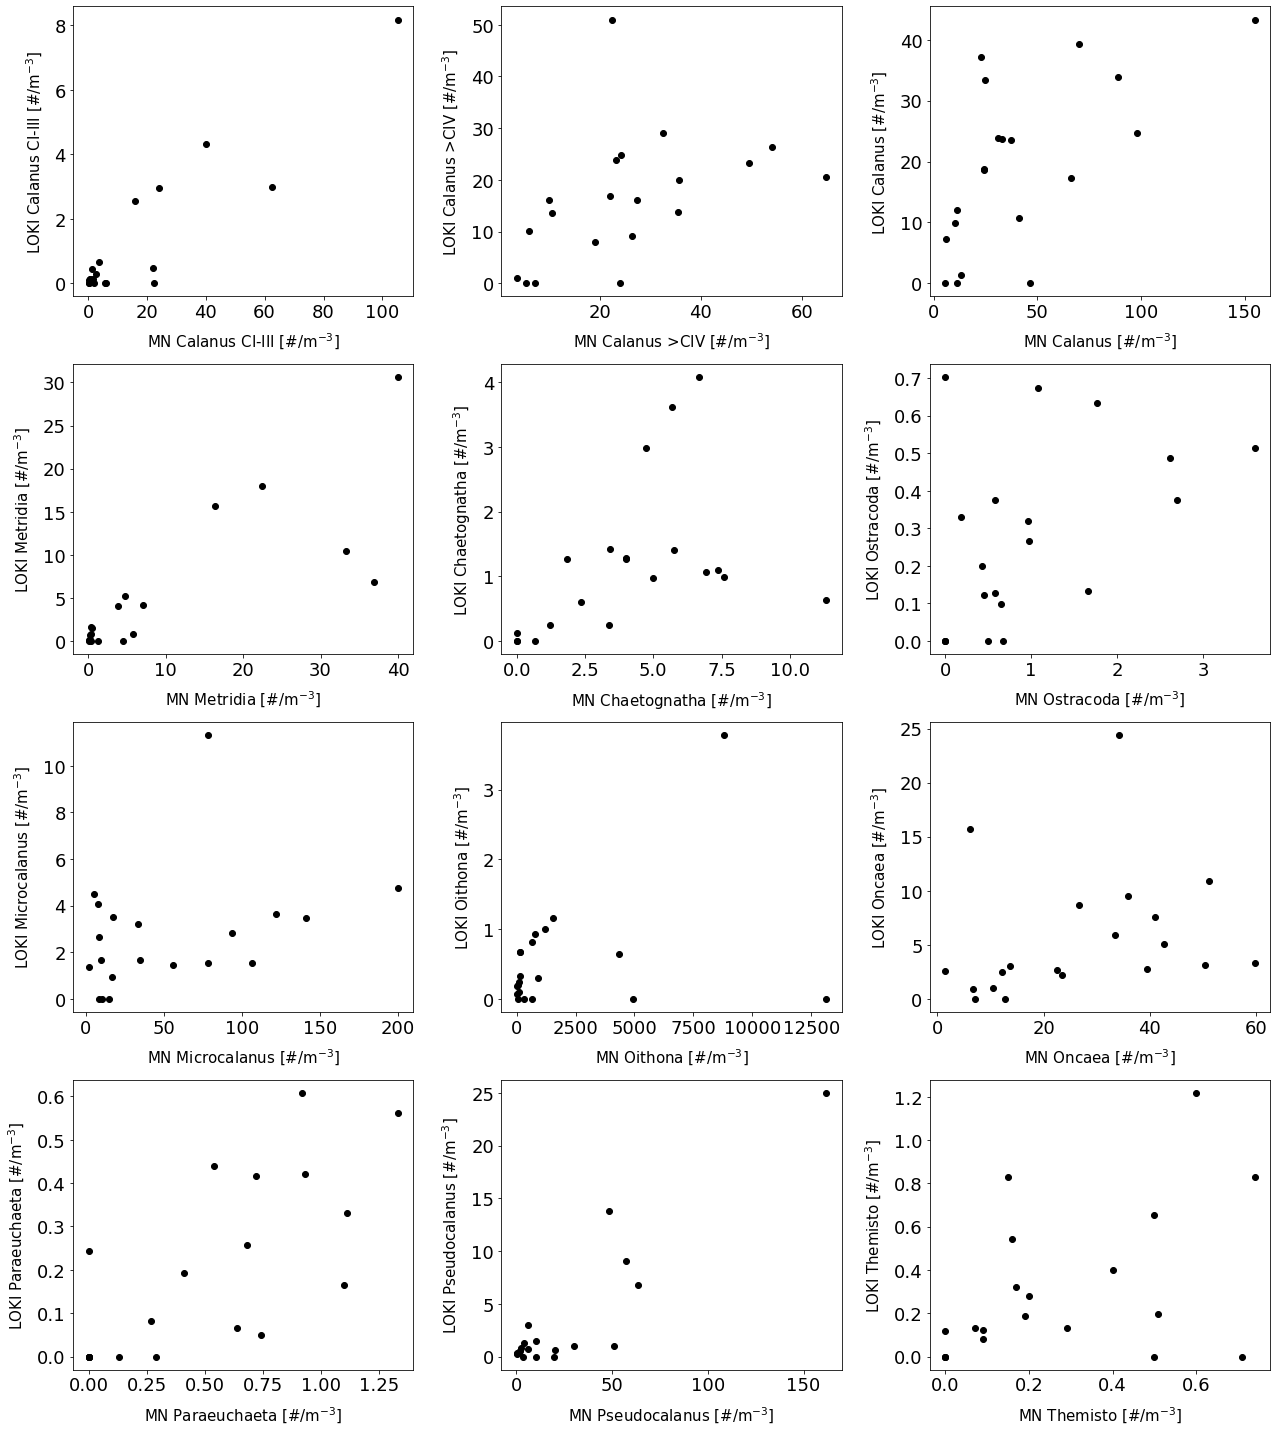

In [152]:
fig = plt.figure(constrained_layout=False, figsize =(18, 20))
gs = fig.add_gridspec(4, 3)

title = ['Calanus CI-III', 'Calanus >CIV', 'Calanus', 'Metridia', 'Chaetognatha', 'Ostracoda', 
         'Microcalanus', 'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']

row = [0, 1, 2, 3]
col = [0, 1, 2]
n = 0
for r in row:
    for c in col:
        ax = fig.add_subplot(gs[r,c])
        
        ax.scatter(mn_all_df['%s' % (title[n],)], mn_all_df['l_%s'% (title[n],)] , color='black')
        ax.set_xlabel('MN %s [#/m$^{-3}$]' % (title[n],), color = 'black', fontsize=15, labelpad =10)
        ax.set_ylabel('LOKI %s [#/m$^{-3}$]' % (title[n],), color = 'black', fontsize=15, labelpad =10)
        ax.tick_params(axis='both', labelsize=18)
        
        n += 1

fig.tight_layout()

plt.savefig(os.path.join(plt_path,'MN_LOKI_comp.pdf'), dpi=300)
plt.show()
plt.close()


In [ ]:
mes_slope, mes_intercept, mes_cor, mes_p, mes_std = stats.linregress(mn_all_df['Metridia CI-III'].to_list(), mn_all_df['l_Metridia CI-III'].to_list())
mel_slope, mel_intercept, mel_cor, mel_p, mel_std = stats.linregress(mn_all_df['Metridia >CIV'].to_list(), mn_all_df['l_Metridia >CIV'].to_list())
cals_slope, cals_intercept, cals_cor, cals_p, cals_std = stats.linregress(mn_all_df['Calanus CI-III'].to_list(), mn_all_df['l_Calanus CI-III'].to_list())
call_slope, call_intercept, call_cor, call_p, call_std = stats.linregress(mn_all_df['Calanus >CIV'].to_list(), mn_all_df['l_Calanus >CIV'].to_list())
os_slope, os_intercept, os_cor, os_p, os_std = stats.linregress(mn_all_df['Ostracoda'].to_list(), mn_all_df['l_Ostracoda'].to_list())
cha_slope, cha_intercept, cha_cor, cha_p, cha_std = stats.linregress(mn_all_df['Chaetognatha'].to_list(), mn_all_df['l_Chaetognatha'].to_list())
mi_slope, mi_intercept, mi_cor, mi_p, mi_std = stats.linregress(mn_all_df['Microcalanus'].to_list(), mn_all_df['l_Microcalanus'].to_list())
oi_slope, oi_intercept, oi_cor, oi_p, oi_std = stats.linregress(mn_all_df['Oithona'].to_list(), mn_all_df['l_Oithona'].to_list())
onc_slope, onc_intercept, onc_cor, onc_p, onc_std = stats.linregress(mn_all_df['Oncaea'].to_list(), mn_all_df['l_Oncaea'].to_list())
par_slope, par_intercept, par_cor, par_p, par_std = stats.linregress(mn_all_df['Paraeuchaeta'].to_list(), mn_all_df['l_Paraeuchaeta'].to_list())
pse_slope, pse_intercept, pse_cor, pse_p, pse_std = stats.linregress(mn_all_df['Pseudocalanus'].to_list(), mn_all_df['l_Pseudocalanus'].to_list())
the_slope, the_intercept, the_cor, the_p, the_std = stats.linregress(mn_all_df['Themisto'].to_list(), mn_all_df['l_Themisto'].to_list())